In [ ]:
!pip install --upgrade diffusers transformers scipy

In [ ]:
!pip install accelerate

In [47]:
! pip install pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install sentence_transformers

In [ ]:
!huggingface-cli login

In [49]:
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline
import tensorflow as tf
from PIL import Image

model_id = "CompVis/stable-diffusion-v1-4"
device = "cuda"

In [2]:
pipe = StableDiffusionPipeline.from_pretrained(model_id, use_auth_token=True)
pipe = pipe.to(device)

Downloading:   0%|          | 0.00/543 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/313 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/592 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/492M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/806 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/743 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/522 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


In [120]:
VGG16 = tf.keras.applications.VGG16(include_top=True, weights='imagenet')
x = VGG16.layers[-2].output
VGG16_MODEL = tf.keras.Model(inputs = VGG16.input, outputs = x)
VGG16_MODEL.trainable = False
VGG16_MODEL.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [3]:
def get_image_stable_diffusion(prompt):
  with autocast("cuda"):
    image = pipe(prompt, guidance_scale=7.5) 
    
  # image.save("image.png")
  img = image.images[0]
  return img

In [114]:
img1 = get_image_stable_diffusion("A painting of a baby riding a bike")
img2 = get_image_stable_diffusion("A painting of a baby riding a bike")

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

In [115]:
size = 224, 224

In [116]:
img1.thumbnail(size)
img2.thumbnail(size)

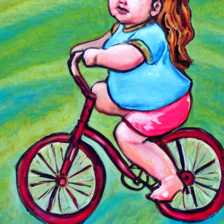

In [117]:
img1

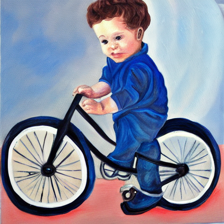

In [118]:
img2

In [119]:
from tensorflow.keras.utils import img_to_array
# convert the image pixels to a numpy array
np_img1 = img_to_array(img1)
np_img_vgg1 = np_img1.reshape((1, np_img1.shape[0], np_img1.shape[1], np_img1.shape[2]))
np_img2 = img_to_array(img2)
np_img_vgg2 = np_img2.reshape((1, np_img2.shape[0], np_img2.shape[1], np_img2.shape[2]))

In [121]:
# getting image embeddings from VGG model
emb_img1 = VGG16_MODEL.predict(np_img_vgg1)
emb_img2 = VGG16_MODEL.predict(np_img_vgg2)

1/1 [==============================] - 0s 17ms/step


# L2 norm

In [125]:
# Helper functions
def image_to_feature_vector(img):
    return np.array(tf.squeeze(VGG16_MODEL(tf.expand_dims(img, 0))))

from numpy.linalg import norm
def similarity(v1, v2):
    v1 /= norm(v1)
    v2 /= norm(v2)
    return 1. - norm(v2 - v1)

In [126]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

image1 = tf.image.resize_with_pad(np_img1, 224, 224)
# Normalize
image1 = tf.math.divide(image1, 255.)
image1 = tf.math.subtract(image1, mean)
image1 = tf.math.divide(image1, std)
image1 = image_to_feature_vector(image1)

image2 = tf.image.resize_with_pad(np_img2, 224, 224)
# Normalize
image2 = tf.math.divide(image2, 255.)
image2 = tf.math.subtract(image2, mean)
image2 = tf.math.divide(image2, std)
image2 = image_to_feature_vector(image2)

sim = similarity(image1, image2)

In [128]:
print("The similarity between two images:", sim)

The similarity between two images: 0.7357053756713867


# Using sentence-transformers

In [133]:
from sentence_transformers import SentenceTransformer, util
from PIL import Image
import glob
import os

# Load the OpenAI CLIP Model
print('Loading CLIP Model...')
model = SentenceTransformer('clip-ViT-B-32')

encoded_image = model.encode([img1, img2], batch_size=128, convert_to_tensor=True, show_progress_bar=True)
processed_images = util.paraphrase_mining_embeddings(encoded_image)

Loading CLIP Model...


ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [134]:
encoded_image

tensor([[ 0.1219,  0.2972,  0.0666,  ...,  0.0674,  0.0991,  0.0038],
        [ 0.2674,  0.1302,  0.1144,  ...,  0.0580,  0.2873, -0.0402]],
       device='cuda:0')

In [135]:
processed_images

[[0.9090005159378052, 0, 1]]

In [136]:
print("Similarity using dense vector representation of CLIP model:", processed_images[0][0])

Similarity using dense vector representation of CLIP model: 0.9090005159378052
